Running totalVI on GPU 

In [1]:
# set-up environment
import anndata, numpy as np, pandas as pd, lpy, scanpy as sc, imp, re
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.1


In [2]:
# load data and filter cells 
adata = anndata.read_h5ad("N2-pbmc.h5ad")
cellsubset = (adata.obs["filtered_cells"] == False)&(adata.obs["DonorSubset"] == True)&(adata.obs["Sort"] == "None")

In [3]:
# prepare data for scVI
sp = lpy.scvi_prepare(adata, "sample_names", cellsubset, nbgenes = 0, use_ccfilter_prefix = "", genes_to_filter = adata.var_names[adata.var["feature_types"] == "Antibody Capture"])

[2021-02-26 16:57:48,746] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-02-26 16:57:48,748] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-02-26 16:57:49,192] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-02-26 16:57:49,271] INFO - scvi.dataset.dataset | Downsampled from 13086 to 13086 cells
[2021-02-26 16:57:49,569] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-02-26 16:57:49,572] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-02-26 16:57:49,908] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-02-26 16:57:49,970] INFO - scvi.dataset.dataset | Downsampled from 12747 to 12747 cells
[2021-02-26 16:57:50,199] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-02-26 16:57:50,202] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-02-26 16:57:50,452] INFO - scvi.dataset.dataset | Computing the library size for the new data

In [4]:
# run scVI
latent = lpy.runSCVI(sp["dataset"])

[2021-02-26 16:58:24,258] INFO - scvi.inference.inference | KL warmup for 400 epochs


In [5]:
# store the generated latent variables in the object and produce UMAP coordinates 
adata = lpy.insertLatent(adata, latent, "scvi_subset_cc", "X_umap_scvi_subset_cc", None, "leiden_scvi_subset_cc", cellnames = sp["names"])
adata = lpy.insertLatent(adata, latent, None, None, None, "leidenres2_scvi_subset_cc", cellnames = sp["names"], leiden_resolution = 2)

defining permutation
Inserting Latent coords
computing UMAP
Inserting Umap coords
Finding clusters
Inserting Cluster Id
defining permutation
Finding clusters
Inserting Cluster Id


In [8]:
# prepare data for totalVI
sp = lpy.scvi_prepare(adata, "sample_names", cellsubset, nbgenes = 0, citeseqfeaturename = "Antibody Capture", use_ccfilter_prefix = "")

[2021-02-26 20:57:06,150] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-02-26 20:57:06,153] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-02-26 20:57:06,547] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-02-26 20:57:06,620] INFO - scvi.dataset.dataset | Downsampled from 13086 to 13086 cells
[2021-02-26 20:57:06,904] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-02-26 20:57:06,907] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-02-26 20:57:07,196] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-02-26 20:57:07,253] INFO - scvi.dataset.dataset | Downsampled from 12747 to 12747 cells
[2021-02-26 20:57:07,478] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-02-26 20:57:07,480] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-02-26 20:57:07,688] INFO - scvi.dataset.dataset | Computing the library size for the new data

In [9]:
# run totalVI
latent = lpy.runTotalVi(sp["dataset"])

[2021-02-26 20:57:33,403] INFO - scvi.inference.inference | KL warmup for 73131.75 iterations


[2021-02-26 22:43:59,533] INFO - scvi.inference.trainer | Reducing LR on epoch 248.
[2021-02-26 22:50:26,115] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2021-02-26 22:50:26,151] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.



In [10]:
# store the generated latent variables in the object and produce UMAP coordinates 
adata = lpy.insertLatent(adata, latent, "tvi_subset_cc", "X_umap_tvi_subset_cc", None, "leiden_tvi_subset_cc", cellnames = sp["names"])
adata = lpy.insertLatent(adata, latent, None, None, None, "leidenres2_tvi_subset_cc", cellnames = sp["names"], leiden_resolution = 2)

defining permutation
Inserting Latent coords
computing UMAP
Inserting Umap coords
Finding clusters
Inserting Cluster Id
defining permutation
Finding clusters
Inserting Cluster Id


In [11]:
# save the object
adata.write_h5ad("N3-pbmc.h5ad")

... storing 'leiden_tvi_subset_cc' as categorical
... storing 'leidenres2_tvi_subset_cc' as categorical


In [13]:
# prepare object for analysis
# filtering cells with high mitochondrial content (>20%) and doublets
adata = adata[adata.obs['filtered_cells'] == False].copy()
adata

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 308920 × 33759
    obs: 'souporcell', 'demultiplexed', 'sample_names', 'log2p1_count', 'percent_mito', 'n_genes', 'batch', 'FolderName', 'Lane', 'Sort', 'Type', 'Donor Id', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing Hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', 'scrublet_pred', 'scrublet_local_pred', 'scrublet_score', 'scrublet_cluster_score', 'filtered_cells', 'S_score', 'G2M_score', 'phase', 'leiden_sampl_cc', 'leidenres2_sampl_cc', 'DonorSubset', 'leiden_scvi_subset_cc', 'leidenres2_scvi_subset_cc', 'leiden_tvi_subset_cc', 'leidenres2_tvi_subset_cc'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'phase_color

In [14]:
# keeping only data from PBMCs
adata = adata[adata.obs['Sort'] == "None"].copy()
adata

AnnData object with n_obs × n_vars = 183649 × 33759
    obs: 'souporcell', 'demultiplexed', 'sample_names', 'log2p1_count', 'percent_mito', 'n_genes', 'batch', 'FolderName', 'Lane', 'Sort', 'Type', 'Donor Id', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing Hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', 'scrublet_pred', 'scrublet_local_pred', 'scrublet_score', 'scrublet_cluster_score', 'filtered_cells', 'S_score', 'G2M_score', 'phase', 'leiden_sampl_cc', 'leidenres2_sampl_cc', 'DonorSubset', 'leiden_scvi_subset_cc', 'leidenres2_scvi_subset_cc', 'leiden_tvi_subset_cc', 'leidenres2_tvi_subset_cc'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'phase_color

In [15]:
# filtering donors
adata = adata[adata.obs['DonorSubset'] == True].copy()
adata

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 97509 × 33759
    obs: 'souporcell', 'demultiplexed', 'sample_names', 'log2p1_count', 'percent_mito', 'n_genes', 'batch', 'FolderName', 'Lane', 'Sort', 'Type', 'Donor Id', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing Hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', 'scrublet_pred', 'scrublet_local_pred', 'scrublet_score', 'scrublet_cluster_score', 'filtered_cells', 'S_score', 'G2M_score', 'phase', 'leiden_sampl_cc', 'leidenres2_sampl_cc', 'DonorSubset', 'leiden_scvi_subset_cc', 'leidenres2_scvi_subset_cc', 'leiden_tvi_subset_cc', 'leidenres2_tvi_subset_cc'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'phase_colors

In [16]:
# filtering cells with fewer than 200 genes
sc.pp.filter_cells(adata, min_genes = 200)

filtered out 10 cells that have less than 200 genes expressed


In [17]:
# filtering lowly expressed genes (<3 cells)
sc.pp.filter_genes(adata, min_cells = 3)

filtered out 11187 genes that are detected in less than 3 cells


In [18]:
adata

AnnData object with n_obs × n_vars = 97499 × 22572
    obs: 'souporcell', 'demultiplexed', 'sample_names', 'log2p1_count', 'percent_mito', 'n_genes', 'batch', 'FolderName', 'Lane', 'Sort', 'Type', 'Donor Id', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing Hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', 'scrublet_pred', 'scrublet_local_pred', 'scrublet_score', 'scrublet_cluster_score', 'filtered_cells', 'S_score', 'G2M_score', 'phase', 'leiden_sampl_cc', 'leidenres2_sampl_cc', 'DonorSubset', 'leiden_scvi_subset_cc', 'leidenres2_scvi_subset_cc', 'leiden_tvi_subset_cc', 'leidenres2_tvi_subset_cc'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'phase_colors

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:17)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 57 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:07)


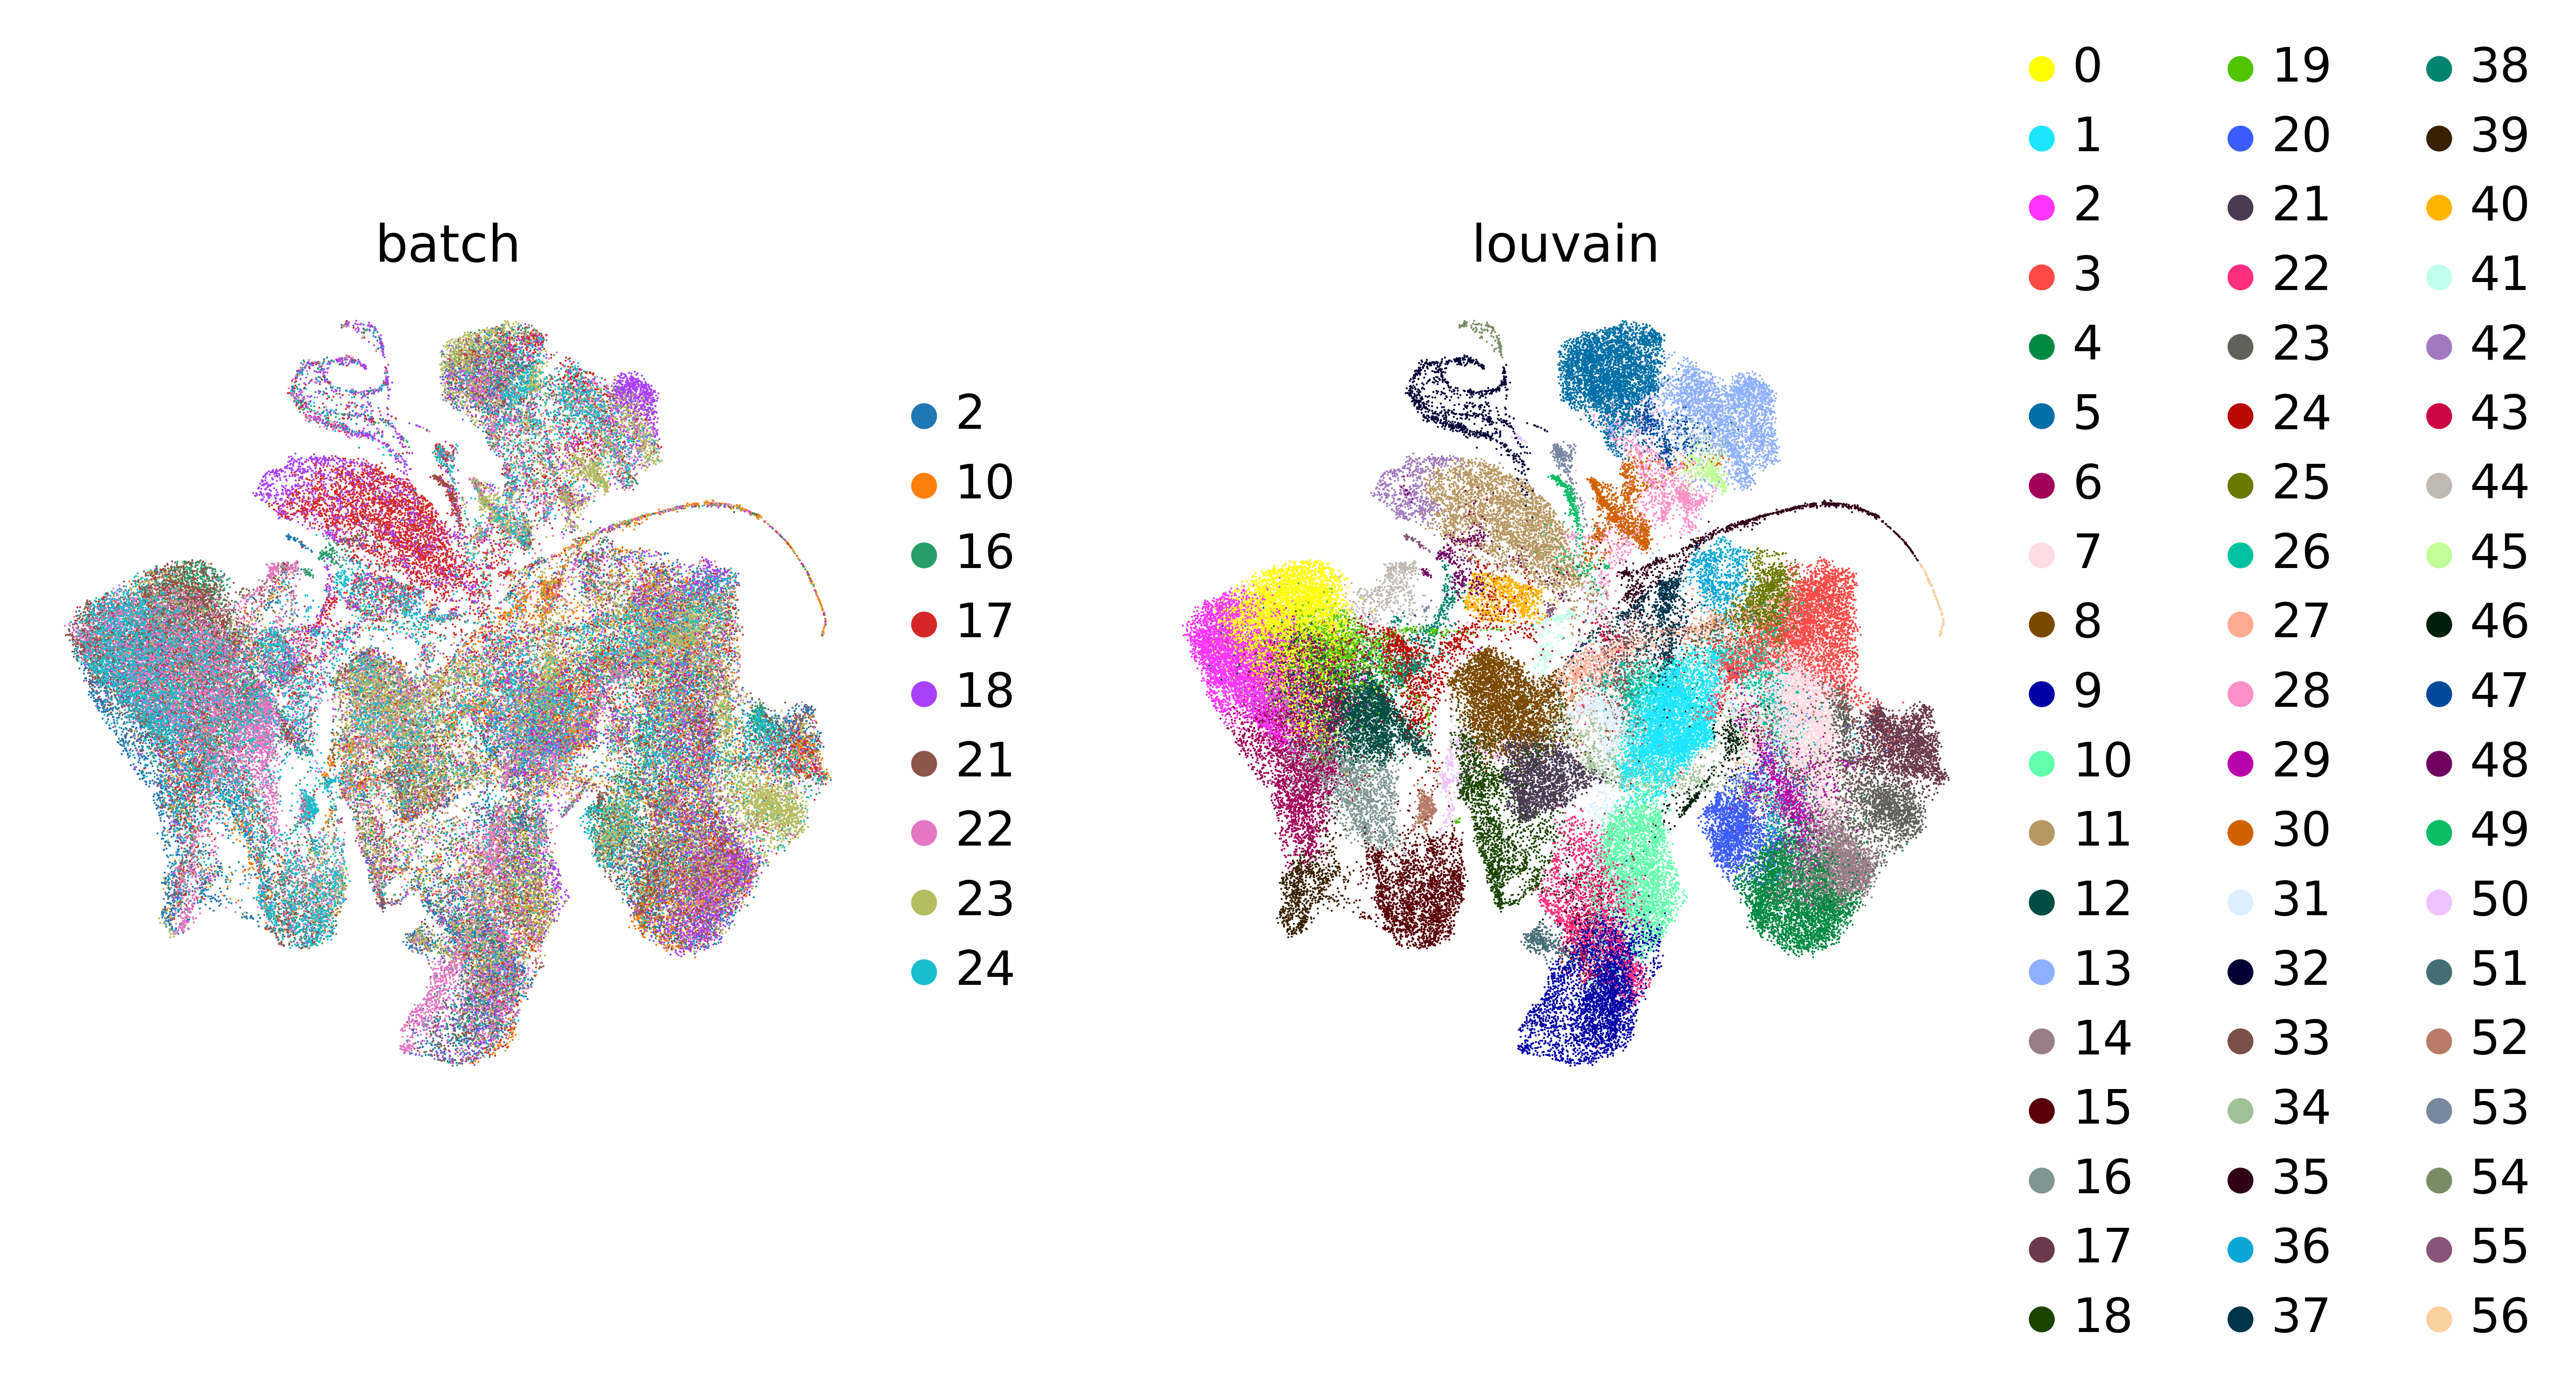

CPU times: user 7min 34s, sys: 7min 53s, total: 15min 27s
Wall time: 3min 41s


In [20]:
%%time
# plotting with the latent representation
sc.pp.neighbors(adata, use_rep = "tvi_subset_cc", n_neighbors = 10, n_pcs = 64)
sc.tl.umap(adata, random_state = 0)
sc.tl.louvain(adata, resolution = 2.0)
sc.pl.umap(adata, color = ["batch", "louvain"], frameon = False)

In [21]:
# saving the filtered object
adata.write_h5ad("N3-pbmc-filtered.h5ad")

End of Notebook